In [ ]:
import xarray as xr, pandas as pd, numpy as np, xoak
from xclim.core.units import convert_units_to
from datetime import datetime

import cartopy, regionmask, geopandas as gpd
from shapely.geometry import Polygon

import glob, re
from matplotlib import pyplot as plt

my_dir = "/home/jovyan/my_materials/"
data_path = "/home/jovyan/shared_materials/climattr_data_please-dont-copy/zarr/"

sf = gpd.read_file("sf_studyregion")


# method to wrap longitude from (0,360) to (-180,180)
def wrap_lon(ds):
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

# List all the available models

In [102]:
domain = "EUR-11"      # either EUR-11 or AFR-22
varnm = "tasmax"       # either tasmax or pr

units = {"tasmax" : "degC", "pr" : "mm/day"}[varnm]

fl = glob.glob(data_path+varnm+"_"+domain+"*.zarr")

# Extract subsets of climate model data

## Monthly spatial pattern

In [78]:
# Identify a larger region around the study region, to check the spatial pattern of temperature / precip in the wider region
xn,xx,yn,yx = [sf.geometry.bounds.minx[0] - 5, sf.geometry.bounds.maxx[0] + 5, sf.geometry.bounds.miny[0] - 5, sf.geometry.bounds.maxy[0] + 5]

In [79]:
for fnm in fl:

    # load the data
    da = xr.open_zarr(fnm)[varnm]
    da = wrap_lon(da)

    # select only the climatological period
    da = da.sel(time = slice("1990", "2020"))

    # convert to the same units as ERA5
    da = convert_units_to(da, units)

    # different RCMs use different coordinate systems, so identify the x & y dims
    if "rlon" in da.dims:
        xdim,ydim = ["rlon", "rlat"]
    else:
        xdim,ydim = ["x", "y"]
        
    # identify a region containing the box we're interested in 
    # (can't use lat & lon directly since CORDEX data uses different projections)
    rm = np.logical_and(np.logical_and(da.lon >= xn, da.lon <= xx), np.logical_and(da.lat >= yn, da.lat <= yx))
    rm = rm.load().where(rm == 1, drop = True)

    # cut out the subset of the region
    da = da.sel({xdim : rm[xdim], ydim : rm[ydim]})

    # get monthly means & save
    da_m = da.groupby("time.month").mean()
    da_m.to_netcdf(my_dir+"spatial_"+fnm.split("/")[-1][:-5]+".nc")

## Daily time series

In [103]:
for fnm in fl:

    # load the data
    da = xr.open_zarr(fnm)[varnm]
    da = wrap_lon(da)

    # convert to the same units as ERA5
    da = convert_units_to(da, units)

    # different RCMs use different coordinate systems, so identify the x & y dims
    if "rlon" in da.dims:
        xdim,ydim = ["rlon", "rlat"]
    else:
        xdim,ydim = ["x", "y"]

    # make a regionmask from your shapefile
    rm = regionmask.mask_geopandas(sf, da.lon, da.lat)

    # compute time series of mean over region
    ts = da.where(rm == 0, drop = True).mean([xdim, ydim])

    ts.to_netcdf(my_dir+"daily_"+fnm.split("/")[-1][:-5]+".nc")

## Annual time series for attribution

In [104]:
ts_fl = glob.glob(my_dir+"daily*.nc")

In [107]:
for fnm in ts_fl:

    # load the data
    ts = xr.open_dataset(fnm)[varnm]

    # use the same definition that you used for the observations
    ts_nday = ts.rolling(time = 1, center = False).mean()            # compute the selected n-day average
    ts_nday = ts_nday.sel(time = ts_nday.time.dt.month.isin([9]))    # choose which months to include in the analysis
    ts_annual = ts_nday.resample(time = "YS-JAN").max()              # get the annual maximum
    
    # relabel dates as years
    ts_annual = ts_annual.assign_coords(time = ts_annual.time.dt.year).rename(time = "year").reset_coords(drop = True)
    
    # save as a .csv to import into R for further analysis
    ts_annual.to_dataframe().to_csv(re.sub("daily","ts-annual",fnm).split("/")[-1][:-5]+".csv")

# Model evaluation

## Seasonal cycle

In [2]:
# load the obs & compute the seasonal cycle over the climatology period
era5 = xr.open_dataset(my_dir+"era5_tmax_daily.nc").tmax
era5_sc = era5.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

In [3]:
# list the available model time series
fl = sorted(glob.glob(my_dir+"daily_*.nc"))

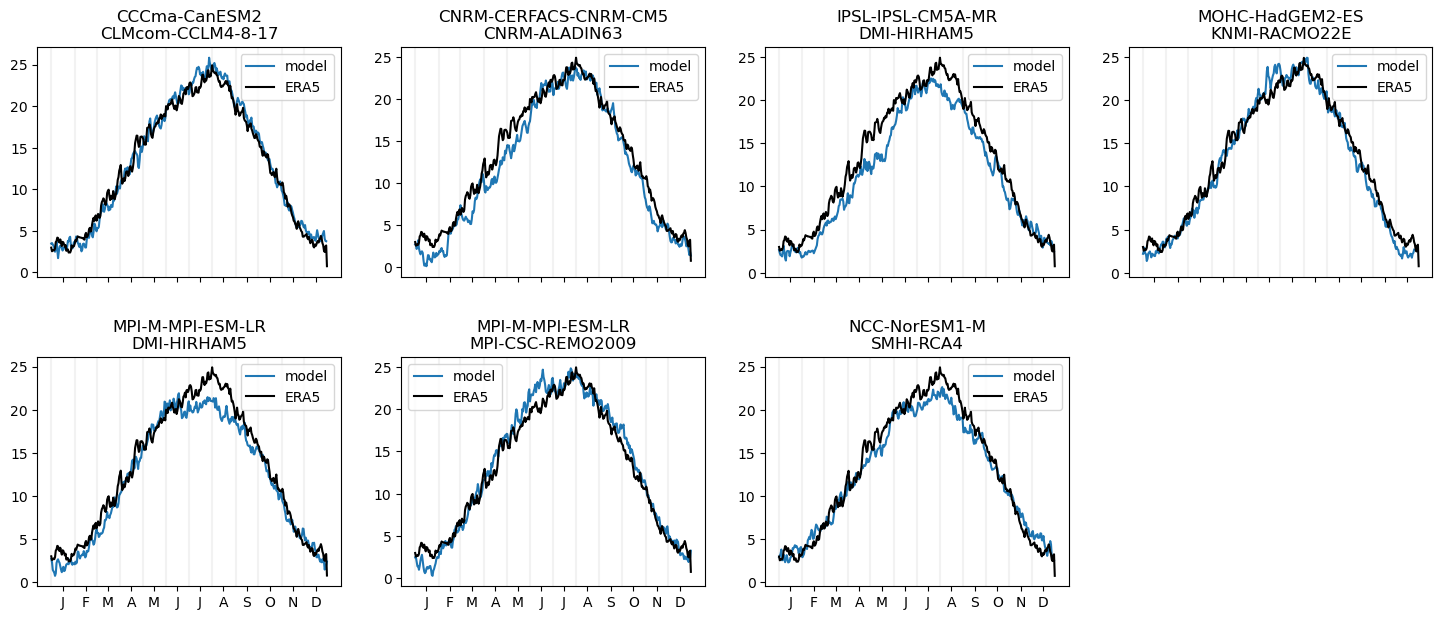

In [5]:
# create an array of subplots
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize = (18,7), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.35)

# get days of the year for nicer x-axis labels
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

for i in range(len(fl)):
    ax = axs.flatten()[i]

    # load data & compute seasonal cycle
    mdl_ts = xr.open_dataset(fl[i]).tasmax
    mdl_sc = mdl_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

    ax.plot(mdl_sc, label = "model")
    ax.plot(era5_sc, color = "k", label = "ERA5")

    # add the model name
    ax.set_title(mdl_ts.gcm.values.tolist() +"\n"+mdl_ts.rcm.values.tolist())
    ax.legend()

    # make nicer x-axis labels
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

for i in range(len(fl), len(axs.flatten())): axs.flatten()[i].set_axis_off()

# save figure
plt.savefig("seasonal-cycles.png")

## Spatial pattern

In [190]:
# Define the plotting area (should be the same area that you cut out in the models)
xn,xx,yn,yx = [sf.geometry.bounds.minx[0] - 5, sf.geometry.bounds.maxx[0] + 5, sf.geometry.bounds.miny[0] - 5, sf.geometry.bounds.maxy[0] + 5]

In [191]:
# load obs and cut out the plotting area
era5 = xr.open_dataset("era5_tmax_daily_eu_5-20E_40-55N_firstyear-lastyear_su.nc").tmax.sel(lon = slice(xn,xx), lat = slice(yx,yn))

# select the month(s) we're interested in and compute the climatology
era5 = era5.sel(time = era5.time.dt.month.isin([9])).sel(time = slice("1990", "2020")).mean("time")

In [192]:
# list the available spatial patterns
fl = sorted(glob.glob(my_dir+"spatial*.nc"))

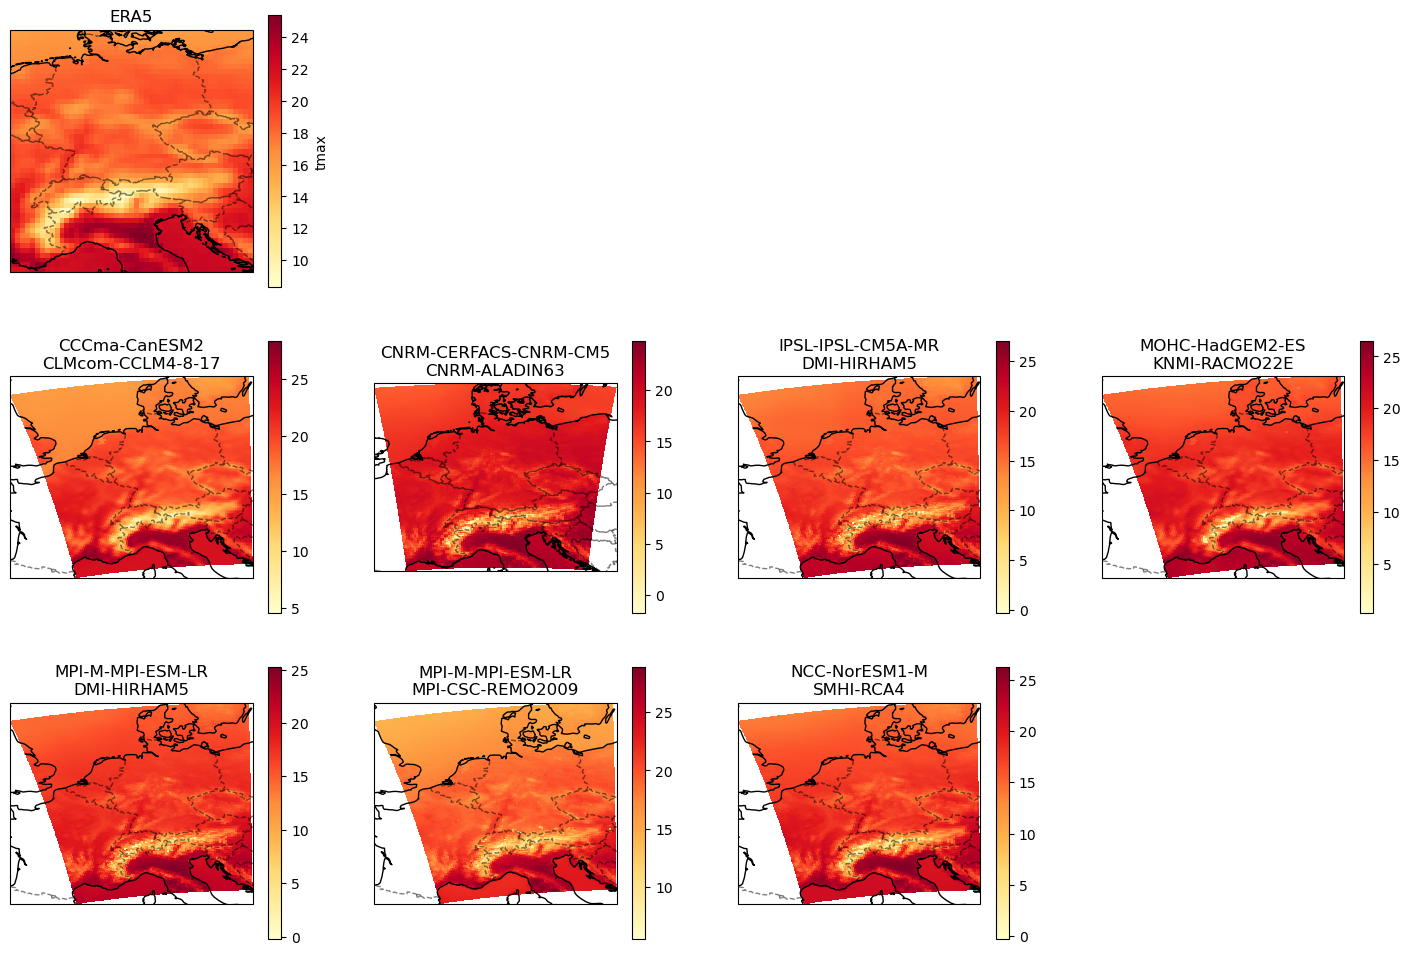

In [193]:
# set some features of the plots
plot_kwargs = {"cmap" : "YlOrRd"}

# create an array of subplots
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (18,12), dpi = 100, subplot_kw = {"projection": cartopy.crs.PlateCarree()})

# plot the obs in the top row
ax = axs[0,0]
era5.plot(ax = ax, **plot_kwargs)
ax.set_title("ERA5")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
    
# plot the climate models below
for i in range(len(fl)):
    ax = axs[1:,:].flatten()[i]
    fnm = fl[i]

    # load the spatial pattern, compute the mean of the months we're interested in
    sp = xr.open_dataset(fnm)[varnm]
    sp = sp.sel(month = sp.month.isin([9])).mean("month")

    # plot the data and add a colourbar (can't be done automatically by xarray due to rotated-pole coordinates)
    cbar = ax.pcolormesh(sp.lon, sp.lat, sp, **plot_kwargs)
    plt.colorbar(cbar, ax = ax)

    # add the model name
    ax.set_title(sp.gcm.values.tolist() +"\n"+sp.rcm.values.tolist())

    # add some geographic features
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")

# tidy up the axes we're not using
for ax in axs[0,1:]: ax.set_axis_off()
for i in range(len(fl), len(axs[1:,:].flatten())): axs[1:,:].flatten()[i].set_axis_off()

# save figure
plt.savefig("spatial-patterns.png")

# Next steps

Repeat this analysis for CMIP6 data (optional) - eg. https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=download

**Next: load the data in R and repeat the statistical analysis for each model**